In [2]:
from IPython.display import display, clear_output
import h5py
import numpy as np
import matplotlib.pyplot as plt
import json

import sys
sys.path.append('/Users/samuelking/Library/CloudStorage/OneDrive-ImperialCollegeLondon/UNI/PhD/CODE/BLANKA_DATA/SCRIPTS')
import preprocess
from preprocess import load_mat_files


In [ ]:
# *** Multiple files load in and globalise keys and values ***

data = load_mat_files(file)
data1 = data['S5_concat_alltrials_-4sto1s.mat']
# Iterate through keys in the dictionary and print their size
for key, value in data1.items():
    if isinstance(value, np.ndarray):  # If the value is a NumPy array
        print(f"{key}: {value.shape}")
    elif isinstance(value, list):  # If the value is a Python list
        print(f"{key} (list): Length {len(value)}")
    else:  # For other data types
        print(f"{key}: {type(value)}, size = {len(value) if hasattr(value, '__len__') else 'N/A'}")


EMG: (1075200, 256)
cut_loc: (1, 105)
fsamp: (1, 1)
state_all: (1, 105)
state_vec: (1, 1075200)
states (list): Length 81
trg_loc: (1, 105)
trial_nr_vec: (1, 1075200)


In [4]:
# *** Single file load in and globalise keys and values ***

# Load the .mat file
file = '/Users/samuelking/Library/CloudStorage/OneDrive-ImperialCollegeLondon/UNI/PhD/CODE/BLANKA_DATA/DATA/DUMMYDATA/S5_concat_alltrials_-4sto1s.mat'

with h5py.File(file, 'r') as f:
    # Print variable names and shapes
    for key in f.keys():
        if f[key].shape == ():  # Scalar dataset (e.g., JSON string)
            value = f[key][()]  # Access scalar dataset
            if key == 'states':  # If it's the `states` key, deserialize the JSON
                value = json.loads(value.decode('utf-8'))  # Decode and load JSON
            globals()[key] = value
            print(f"{key} (list): length {len(globals()[key])}")
        else:  # Non-scalar dataset
            globals()[key] = f[key][:]
            print(f"{key}: {f[key].shape}")
        

EMG: (1075200, 256)
cut_loc: (1, 105)
fsamp: (1, 1)
state_all: (1, 105)
state_vec: (1, 1075200)
states (list): length 81
trg_loc: (1, 105)
trial_nr_vec: (1, 1075200)


	1.	EMG: Main EMG data matrix

	2.	fsamp: Sampling frequency, given as 2048 Hz.

	3.	cut_loc: Blanka "represents locations in the data where it was “cut” during preprocessing. It may mark segments of interest or regions cut out, but it may not be relevant for your analysis.

	4.	trg_loc (Trigger Locations): Timestamps of when triggers were sent.

	5.	state_all and state_vec:
	•	state_all: Value (1 or 2) indiciating the state at each trial (105 trials per .mat)
	•	state_vec: Value (1 or 2) at every timestep indiciating the state

	6.	trial_nr_vec: This appears to be a trial number vector, matching the length of state_vec and EMG. Each entry might represent the trial number associated with each sample, allowing segmentation of the data by trial.
    
	7.	ans: This is a single scalar value (105), which could represent the number of trials or segments in the dataset. This matches with the 105 x 1 dimensions of trg_loc and cut_loc, suggesting each trial might have a unique trigger location and cut point.

	•	Baseline Window (-2s to -1s): A control period before any movement-related neural activity occurs.
    
	•	Preparation Window (-1s to 0s): A critical period for motor preparation, just before participants decide on their action.
    
	•	Cancellation Window (0s to +1s): Captures neural activity during movement inhibition and sustained contraction.

In [4]:
state_all

array([[2., 1., 1., 2., 2., 1., 2., 1., 2., 1., 2., 1., 2., 1., 2., 1.,
        2., 1., 2., 1., 1., 2., 2., 1., 2., 1., 2., 1., 2., 1., 2., 1.,
        2., 1., 2., 2., 1., 2., 1., 2., 1., 1., 2., 1., 2., 1., 2., 1.,
        2., 2., 1., 1., 2., 1., 2., 1., 2., 2., 1., 1., 2., 2., 1., 2.,
        1., 2., 1., 1., 2., 1., 2., 1., 1., 2., 1., 2., 2., 1., 1., 2.,
        2., 1., 1., 2., 2., 1., 2., 1., 1., 2., 1., 2., 2., 1., 1., 2.,
        2., 1., 2., 1., 2., 1., 1., 2., 2.]])

In [5]:
trg_loc

array([[   8192.,   18432.,   28672.,   38912.,   49152.,   59392.,
          69632.,   79872.,   90112.,  100352.,  110592.,  120832.,
         131072.,  141312.,  151552.,  161792.,  172032.,  182272.,
         192512.,  202752.,  212992.,  223232.,  233472.,  243712.,
         253952.,  264192.,  274432.,  284672.,  294912.,  305152.,
         315392.,  325632.,  335872.,  346112.,  356352.,  366592.,
         376832.,  387072.,  397312.,  407552.,  417792.,  428032.,
         438272.,  448512.,  458752.,  468992.,  479232.,  489472.,
         499712.,  509952.,  520192.,  530432.,  540672.,  550912.,
         561152.,  571392.,  581632.,  591872.,  602112.,  612352.,
         622592.,  632832.,  643072.,  653312.,  663552.,  673792.,
         684032.,  694272.,  704512.,  714752.,  724992.,  735232.,
         745472.,  755712.,  765952.,  776192.,  786432.,  796672.,
         806912.,  817152.,  827392.,  837632.,  847872.,  858112.,
         868352.,  878592.,  888832.,  899072., 

In [85]:
# Create STATES dictionary list from state_vec variable

# Flatten state_vec to ensure it's 1D
state_vec_flat = state_vec.flatten()

# Initialize variables
states = []  # List to store the state, start, and end samples
prev_state = state_vec_flat[0]
start_sample = 0

# Loop through the state_vec to identify state transitions
for i, state in enumerate(state_vec_flat):
    if state != prev_state:  # State transition detected
        if prev_state == 1:
            state_label = "NO-GO"
        elif prev_state == 2:
            state_label = "GO"
        # Record the current segment
        states.append({'state_value': prev_state-1, 'start': start_sample, 'end': i - 1, 'state': state_label})
        # Update the start sample for the new state
        start_sample = i
        prev_state = state

# Add the final segment
states.append({'state': prev_state, 'start': start_sample, 'end': len(state_vec) - 1})

# Print or inspect the condensed states
states[0:10]


[{'state_value': 1.0, 'start': 0, 'end': 10239, 'state': 'GO'},
 {'state_value': 0.0, 'start': 10240, 'end': 30719, 'state': 'NO-GO'},
 {'state_value': 1.0, 'start': 30720, 'end': 51199, 'state': 'GO'},
 {'state_value': 0.0, 'start': 51200, 'end': 61439, 'state': 'NO-GO'},
 {'state_value': 1.0, 'start': 61440, 'end': 71679, 'state': 'GO'},
 {'state_value': 0.0, 'start': 71680, 'end': 81919, 'state': 'NO-GO'},
 {'state_value': 1.0, 'start': 81920, 'end': 92159, 'state': 'GO'},
 {'state_value': 0.0, 'start': 92160, 'end': 102399, 'state': 'NO-GO'},
 {'state_value': 1.0, 'start': 102400, 'end': 112639, 'state': 'GO'},
 {'state_value': 0.0, 'start': 112640, 'end': 122879, 'state': 'NO-GO'}]

In [102]:
# CALCULATE STATES OF MAT FILE AND RESAVE INTO FILE 
# Originally 2-Go, 1-No Go

# Define the function to calculate states
def calculate_states(state_vec):
    """
    Converts the state_vec array into a condensed states list with start and end samples.
    """
    # Flatten state_vec to ensure it's 1D
    state_vec_flat = state_vec.flatten()

    # Initialize variables
    states = []
    prev_state = state_vec_flat[0]
    start_sample = 0

    # Loop through state_vec to detect state transitions
    for i, state in enumerate(state_vec_flat):
        if state != prev_state:  # State transition detected
            state_label = "GO" if prev_state == 2 else "NO-GO"
            states.append({
                'state_value': int(prev_state - 1),  # Convert 1 -> 0 (NO-GO) and 2 -> 1 (GO)
                'start': int(start_sample),
                'end': int(i - 1),
                'state': state_label
            })
            # Update for the next segment
            start_sample = i
            prev_state = state

    # Add the final segment
    state_label = "GO" if prev_state == 2 else "NO-GO"
    states.append({
        'state_value': int(prev_state - 1),
        'start': int(start_sample),
        'end': int(len(state_vec_flat) - 1),
        'state': state_label
    })

    return states


# LOOP THROUGH MAT FILES, CALCULATE STATES AND APPEND THEM TO MAT FILES

# Define the directory containing .mat files
directory = '/Users/samuelking/Library/CloudStorage/OneDrive-ImperialCollegeLondon/UNI/PhD/CODE/BLANKA_DATA/DATA'

# Loop through all .mat files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.mat'):
        file_path = os.path.join(directory, filename)

        # Load the .mat file
        with h5py.File(file_path, 'r+') as f:  # 'r+' mode allows read/write
            if 'state_vec' in f:
                # Get state_vec from the file
                state_vec = f['state_vec'][:]

                # Calculate states
                states = calculate_states(state_vec)

                # Check if 'states' key already exists
                if 'states' in f.keys():
                    print(f"'states' already exists in {filename}. Overwriting...")
                    del f['states']  # Delete the existing key

                # Save the states variable into the .mat file
                print(f"Adding 'states' key to {filename}...")
                
                # Save states as JSON-like string in the .mat file
                states_json = json.dumps(states)
                f.create_dataset('states', data=np.string_(states_json))  # Store as a JSON string
            else:
                print(f"'state_vec' not found in {filename}. Skipping...")

print("Processing complete.")

Adding 'states' key to S9_concat_alltrials_-4sto1s.mat...
Adding 'states' key to S7_concat_alltrials_-4sto1s.mat...
Adding 'states' key to S10_concat_alltrials_-4sto1s.mat...
Adding 'states' key to S12_concat_alltrials_-4sto1s.mat...
Adding 'states' key to S5_concat_alltrials_-4sto1s.mat...
Adding 'states' key to S6_concat_alltrials_-4sto1s.mat...
Adding 'states' key to S8_concat_alltrials_-4sto1s.mat...
Processing complete.


In [201]:
# Segment emg data based on cut_loc

emg_data = EMG.T
cut_loc_1d = cut_loc[0, :]  # Convert to a 1D array

def segment_emg_by_cut_loc(emg_data, cut_loc):
    """
    Segments the EMG data according to cut_loc indices.

    Args:
    - emg_data (numpy array): The raw EMG data of shape [channels, time].
    - cut_loc (numpy array): 1D array of indices where cuts/segments start.

    Returns:
    - List of numpy arrays: Segments of EMG data, each as [channels, segment_length].
    """
    segments = []
    
    # Iterate over cut locations and slice the EMG data
    for i in range(len(cut_loc) - 1):
        start_idx = int(cut_loc[i])
        end_idx = int(cut_loc[i + 1])
        segment = emg_data[:, start_idx:end_idx]  # Slice EMG data for the segment
        segments.append(segment)
    
    # # Handle the final segment if necessary
    # last_segment = emg_data[:, int(cut_loc[-1]):]  # Segment from last cut_loc to the end
    # segments.append(last_segment)
    
    return segments

# Call the function
emg_segments = segment_emg_by_cut_loc(emg_data, cut_loc_1d)

# Output the segmented EMG data
for idx, segment in enumerate(emg_segments):
    print(f"Segment {idx + 1}: Shape {segment.shape}")
    if idx == 4:
        print("...")
        break
print(f"Total segments {(len(emg_segments))}")

Segment 1: Shape (256, 10240)
Segment 2: Shape (256, 10240)
Segment 3: Shape (256, 10240)
Segment 4: Shape (256, 10240)
Segment 5: Shape (256, 10240)
...
Total segments 104


/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


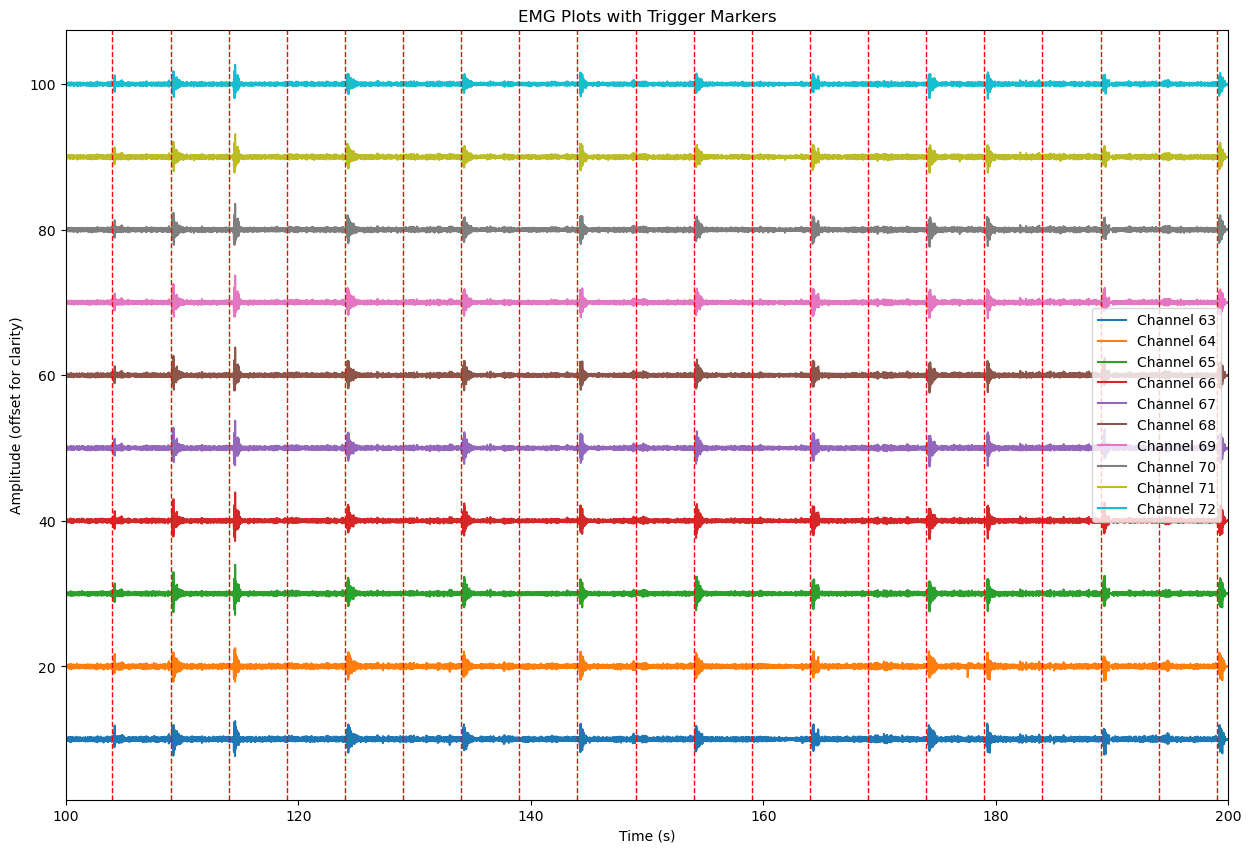

In [6]:
emg_data = EMG.T
fs = fsamp  # Sampling frequency in Hz (adjust as needed)
index = 62
num_channels_to_plot = 10  # Number of channels to plot
selected_channels = emg_data[index:index+num_channels_to_plot, :]  # Select 10 channels
time_axis = np.arange(emg_data.shape[1]) / fs  # Time axis in seconds
time_axis = time_axis.flatten()  # Ensure time_axis is 1D
# Convert trg_loc indices to time (in seconds)
trg_times = trg_loc.flatten() / fs  # Flatten trg_loc to ensure it's 1D


fig, ax = plt.subplots(figsize=(15, 10))
# Initial static plot of the EMG data
lines = []
for i, channel_data in enumerate(selected_channels, start=1):
    line, = ax.plot(time_axis, channel_data + i * 10, label=f'Channel {index + i}')
    lines.append(line)

# Add vertical dashed lines at trigger locations
for trg_time in trg_times[0]:
    ax.axvline(x=trg_time, color='red', linestyle='--', linewidth=1)

# Set plot details
ax.set_title("EMG Plots with Trigger Markers")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude (offset for clarity)")
ax.set_xlim(100, 200)  # Initial x-axis range
ax.legend()

clear_output(wait=True)
plt.show()

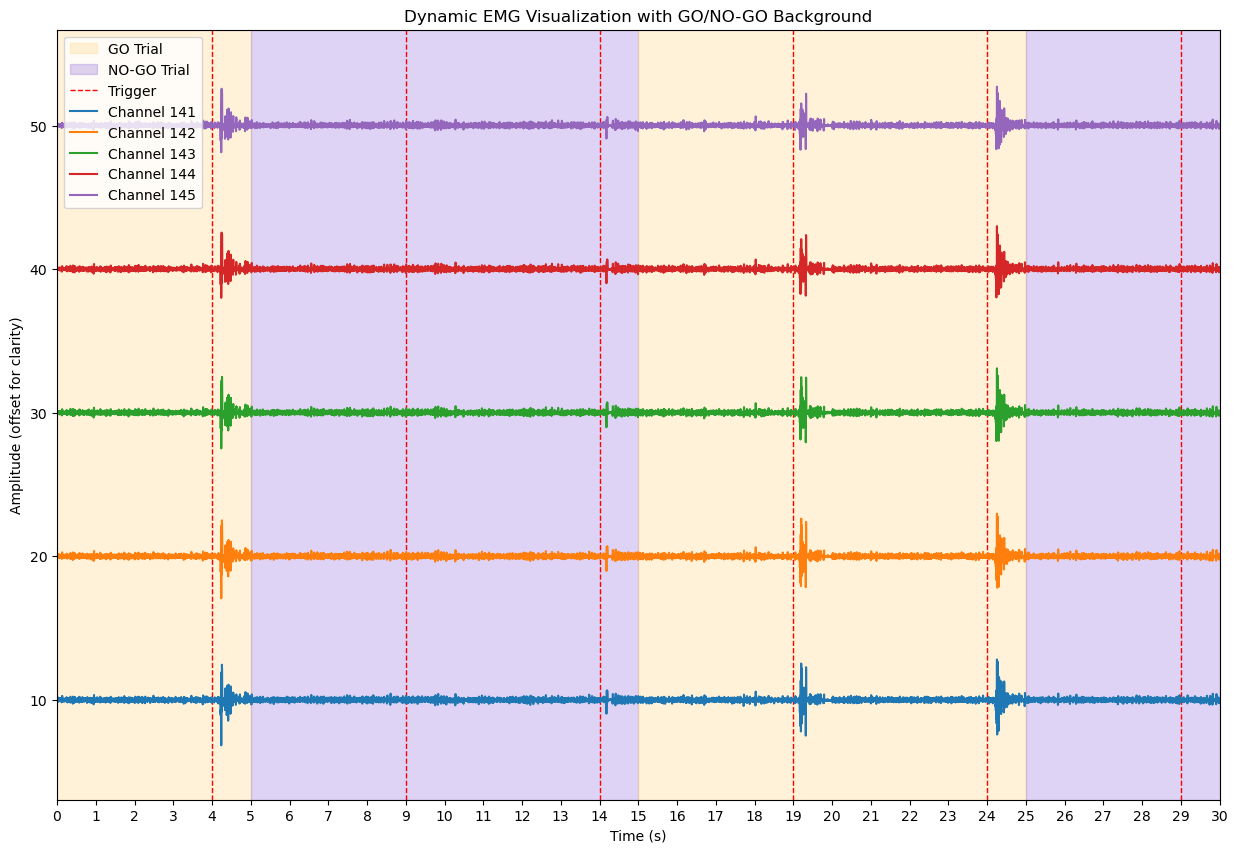

In [8]:
emg_data = EMG.T

fs = fsamp  # Sampling frequency in Hz (adjust as needed)
index = 140
num_channels_to_plot = 5  # Number of channels to plot
selected_channels = emg_data[index:index+num_channels_to_plot, :]  # Select 10 channels
time_axis = np.arange(emg_data.shape[1]) / fs  # Time axis in seconds
time_axis = time_axis.flatten()  # Ensure time_axis is 1D
# Convert trg_loc indices to time (in seconds)
trg_times = trg_loc.flatten() / fs  # Flatten trg_loc to ensure it's 1D

fig, ax = plt.subplots(figsize=(15, 10))

# Add background colors for GO and NO-GO trials using `states`
for state_entry in states:
    start_time = state_entry['start'] / fs  # Convert start sample to time
    end_time = state_entry['end'] / fs  # Convert end sample to time
    state_label = state_entry['state']
    
    if state_label == 'GO':
        ax.axvspan(start_time, end_time, color='#FFD580', alpha=0.3, label='GO Trial' if 'GO Trial' not in ax.get_legend_handles_labels()[1] else "")
    elif state_label == 'NO-GO':
        ax.axvspan(start_time, end_time, color='mediumpurple', alpha=0.3, label='NO-GO Trial' if 'NO-GO Trial' not in ax.get_legend_handles_labels()[1] else "")

# Add vertical dashed lines at trigger locations
for trg_time in trg_times[0]:
    ax.axvline(x=trg_time, color='red', linestyle='--', linewidth=1, label='Trigger' if 'Trigger' not in ax.get_legend_handles_labels()[1] else "")
    
# Plot the EMG data
lines = []
for i, channel_data in enumerate(selected_channels, start=1):
    line, = ax.plot(time_axis, channel_data + i * 10, label=f'Channel {index + i}')
    lines.append(line)


# Set plot details
ax.set_xticks(np.arange(int(time_axis.min()), int(time_axis.max()) + 1, 1))
ax.set_title("Dynamic EMG Visualization with GO/NO-GO Background")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude (offset for clarity)")
ax.set_xlim(0, 30)
ax.legend()

clear_output(wait=True)
plt.show()

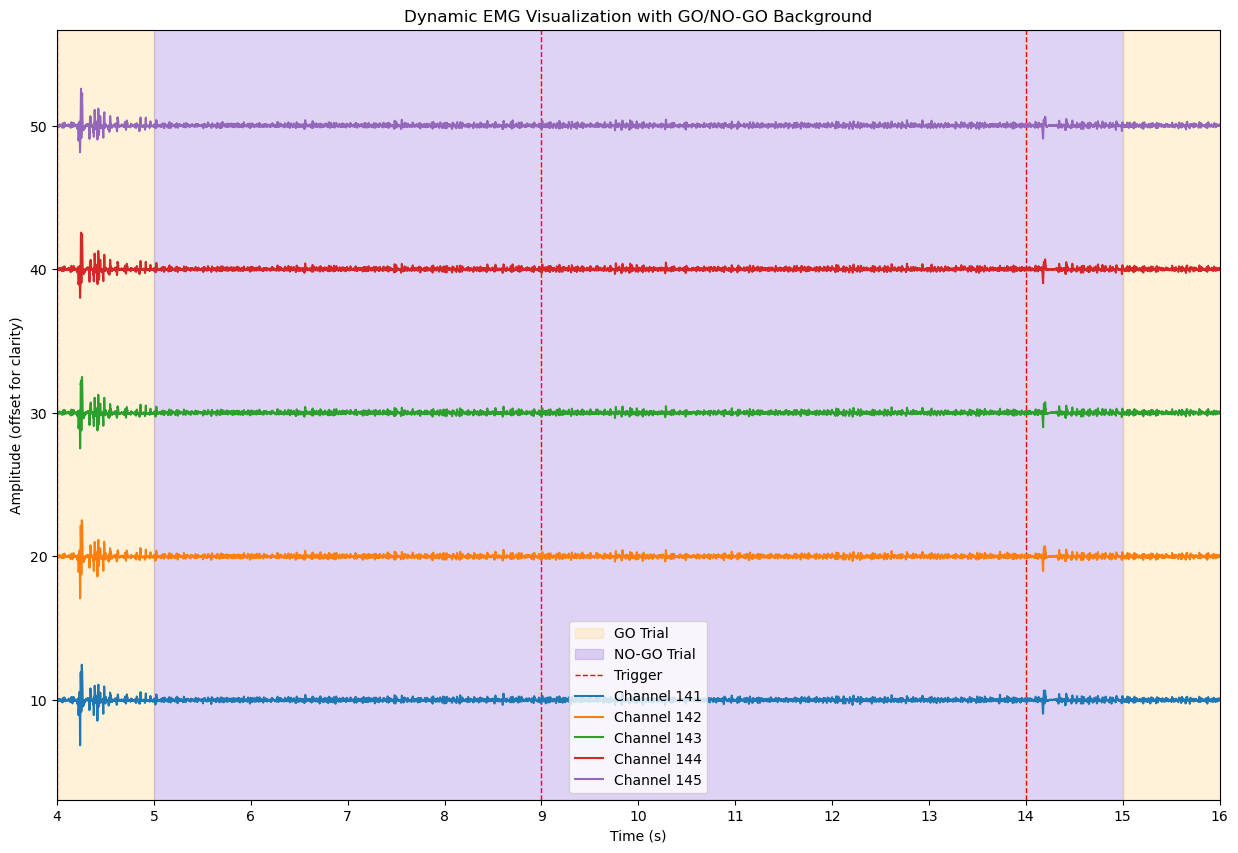

In [7]:
emg_data = EMG.T

fs = fsamp  # Sampling frequency in Hz (adjust as needed)
index = 140
num_channels_to_plot = 5  # Number of channels to plot
selected_channels = emg_data[index:index+num_channels_to_plot, :]  # Select 10 channels
time_axis = np.arange(emg_data.shape[1]) / fs  # Time axis in seconds
time_axis = time_axis.flatten()  # Ensure time_axis is 1D
# Convert trg_loc indices to time (in seconds)
trg_times = trg_loc.flatten() / fs  # Flatten trg_loc to ensure it's 1D

fig, ax = plt.subplots(figsize=(15, 10))

# Add background colors for GO and NO-GO trials using `states`
for state_entry in states:
    start_time = state_entry['start'] / fs  # Convert start sample to time
    end_time = state_entry['end'] / fs  # Convert end sample to time
    state_label = state_entry['state']
    
    if state_label == 'GO':
        ax.axvspan(start_time, end_time, color='#FFD580', alpha=0.3, label='GO Trial' if 'GO Trial' not in ax.get_legend_handles_labels()[1] else "")
    elif state_label == 'NO-GO':
        ax.axvspan(start_time, end_time, color='mediumpurple', alpha=0.3, label='NO-GO Trial' if 'NO-GO Trial' not in ax.get_legend_handles_labels()[1] else "")

# Add vertical dashed lines at trigger locations
for trg_time in trg_times[0]:
    ax.axvline(x=trg_time, color='red', linestyle='--', linewidth=1, label='Trigger' if 'Trigger' not in ax.get_legend_handles_labels()[1] else "")
    
# Plot the EMG data
lines = []
for i, channel_data in enumerate(selected_channels, start=1):
    line, = ax.plot(time_axis, channel_data + i * 10, label=f'Channel {index + i}')
    lines.append(line)


# Set plot details
ax.set_xticks(np.arange(int(time_axis.min()), int(time_axis.max()) + 1, 1))
ax.set_title("Dynamic EMG Visualization with GO/NO-GO Background")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude (offset for clarity)")
ax.set_xlim(4, 16)
ax.legend()

clear_output(wait=True)
plt.show()

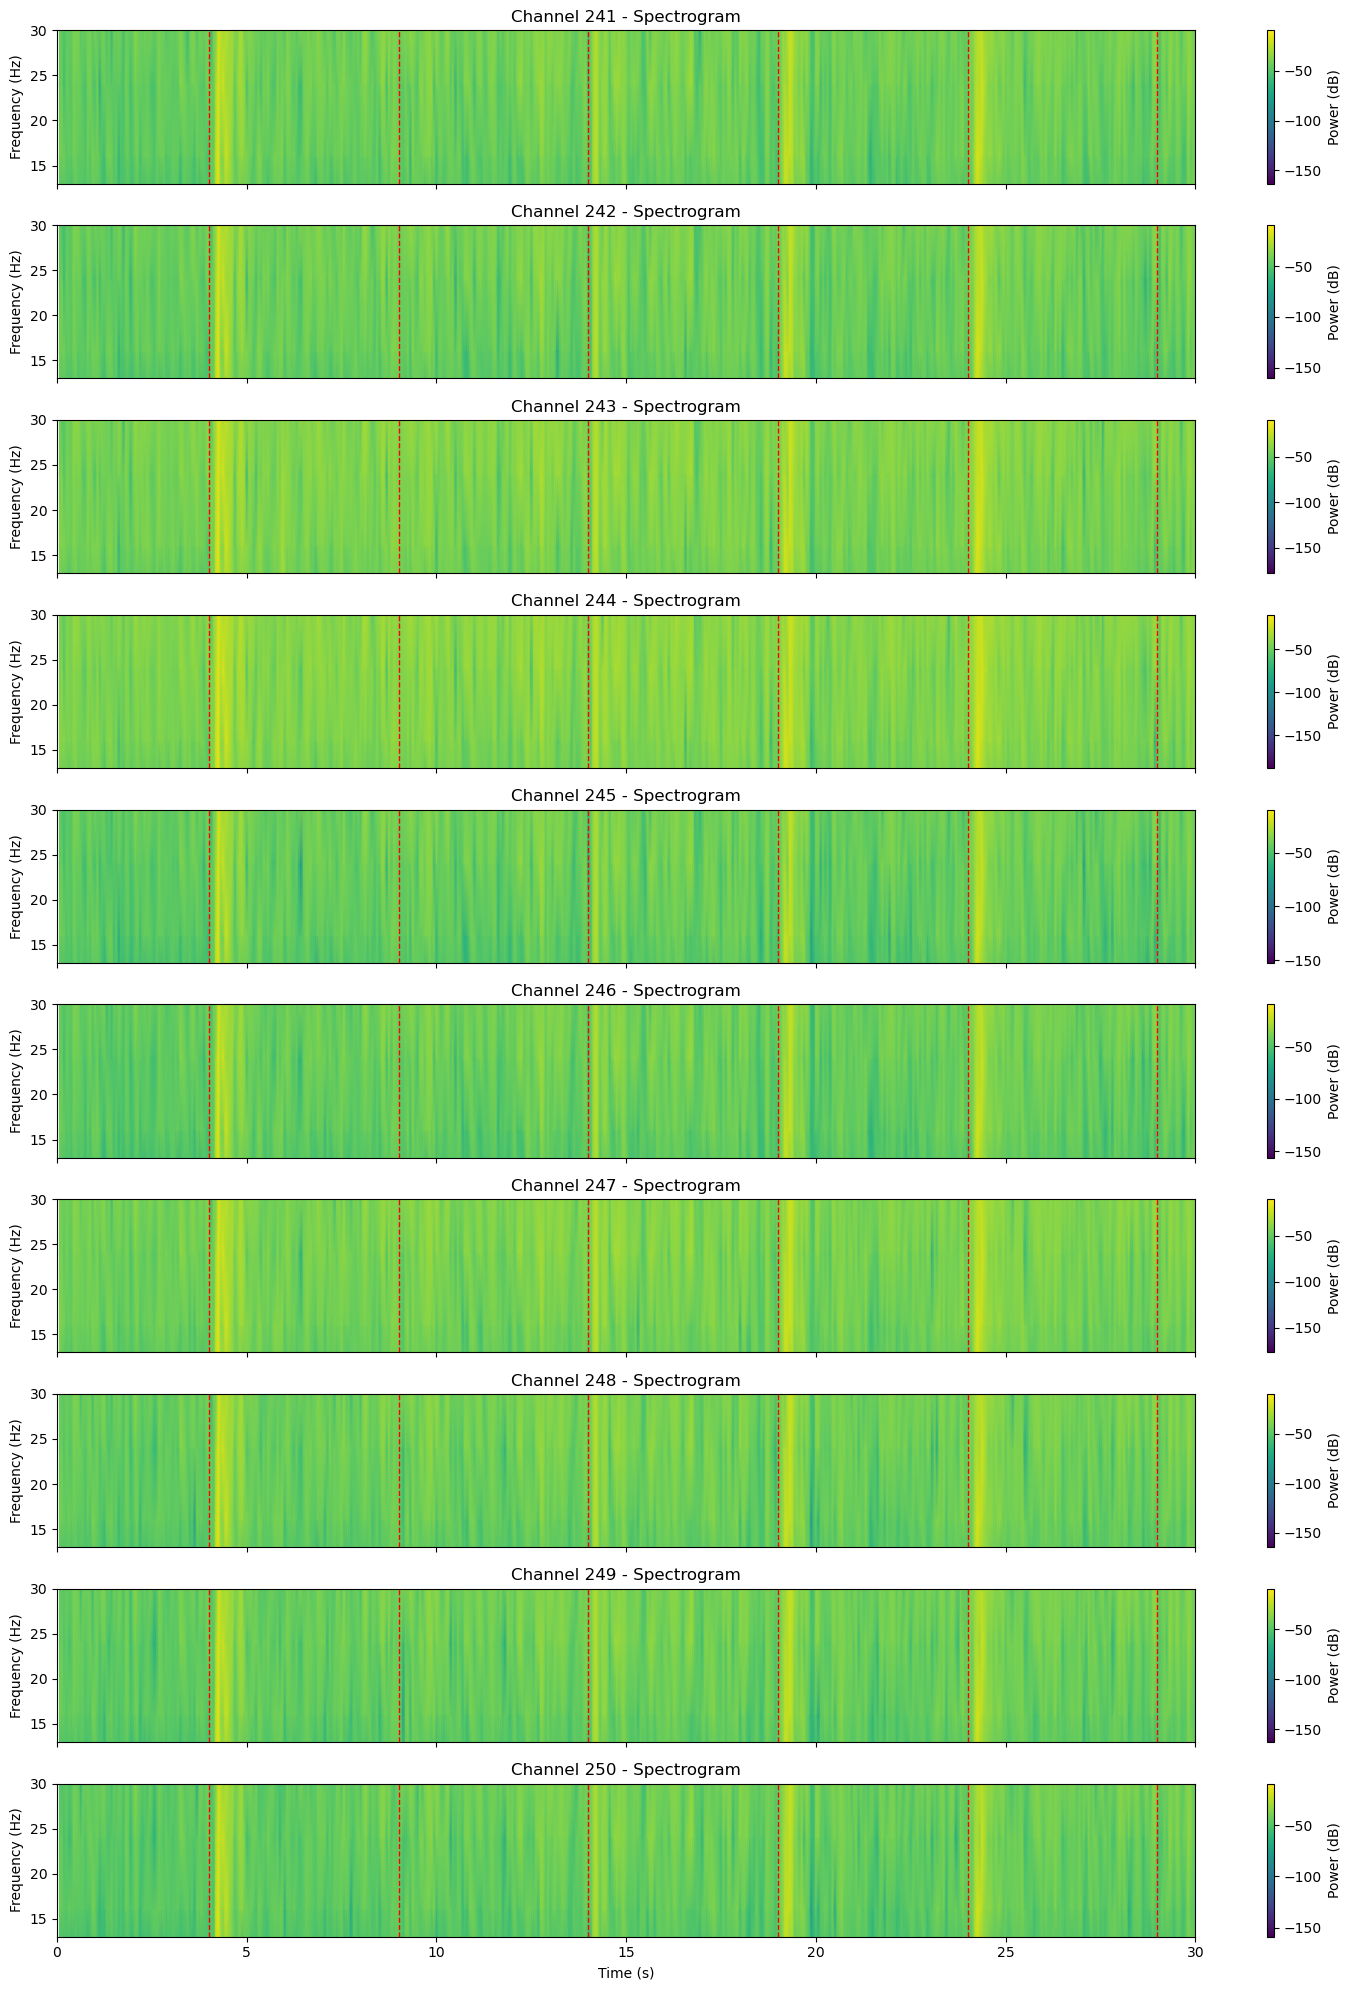

In [199]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

fs = fsamp  # Sampling frequency in Hz
index = 240
num_channels_to_plot = 10  # Number of channels to plot
selected_channels = emg_data[index:index+num_channels_to_plot, :]  # Select channels
time_axis = np.arange(emg_data.shape[1]) / fs  # Time axis in seconds
trg_times = trg_loc.flatten() / fs  # Trigger times in seconds
state_vec = state_vec.flatten()  # Ensure state_vec is 1D

# Parameters for spectrogram
nperseg = 256  # Length of each segment for STFT
noverlap = nperseg // 2  # Overlap between segments
freq_range = (13, 30)  # Beta band frequency range (for visualization)

fig, ax = plt.subplots(num_channels_to_plot, 1, figsize=(15, 20), sharex=True)

for i, (channel_data, axis) in enumerate(zip(selected_channels, ax), start=1):
    # Compute the spectrogram
    f, t, Sxx = spectrogram(channel_data, fs, nperseg=nperseg, noverlap=noverlap)
    
    # Create meshgrid for pcolormesh
    T, F = np.meshgrid(t, f)
    
    # Plot the full spectrogram
    im = axis.pcolormesh(T, F, 10 * np.log10(Sxx), shading='gouraud', cmap='viridis')
    axis.set_ylabel("Frequency (Hz)")
    axis.set_title(f"Channel {index + i} - Spectrogram")
    fig.colorbar(im, ax=axis, orientation='vertical', label='Power (dB)')
    
    # Set x-axis range
    axis.set_xlim(0, 30)  # Adjust as needed for time range in seconds
    
    # Set y-axis range for frequency (beta band or other ranges)
    axis.set_ylim(freq_range)  # Adjust to show desired frequency range
    
    # Add vertical dashed lines for triggers
    for trg_time in trg_times[0]:
        axis.axvline(x=trg_time, color='red', linestyle='--', linewidth=1)

plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()